# Setup

In [1]:
%matplotlib inline
%run util_draw.py
from array import array
import rootpy as rpy
import rootpy.plotting.root2matplotlib as rplt
from rootpy.io import root_open
import numpy as np
import pandas as pd
import ROOT as r
import math
from scipy import interpolate

get_interpf = lambda h: interpolate.interp1d(list(h.x()), list(h.y()), kind='cubic')

MASS_P = 0.93827203

def interp_h1(h, X=None):
    x = list(h.x())
    y = list(h.y())
    if X is None:
        X = list(np.linspace(x[0], x[-1], 10*len(x)))
    return X, np.interp(X, x, y)

def get_interp_h2(h2, XY):
    x = list(h2.x())
    y = list(h2.y())
    z = list(h2.z())
    return interpolate.interp2d(x, y, z, kind='quintic')
    
def get_hsubd(h):
    s = r.TSpectrum()
    hbg = asrootpy(s.Background(h, 5))
    hbg.set_name('%s_bg'%h.get_name())
    hbgsubd = h.clone('%s_bgsubd'%h.get_name())
    hbgsubd.add(hbg, -1)
    return (hbgsubd, hbg, h)

def get_hmmp(W, Q2, fn='../e1f6/test/h6_top1_e1f_exp.root', tpath='h6_mmp_top1/hbd_yield'):
    with root_open(fn) as fin:
        if not isinstance(W, (list, tuple)):
            W = (W,W)
        if not isinstance(Q2, (list, tuple)):
            Q2 = (Q2,Q2)
        h6 = fin[tpath]
        for iax in range(0, 6):
            ax = h6.GetAxis(iax)
            ax.SetRange(1, ax.GetNbins())
        axW = h6.GetAxis(0)
        axQ2 = h6.GetAxis(1)
        Wbin0 = axW.FindBin(W[0])
        Q2bin0 = axQ2.FindBin(Q2[0])
        Wbin1 = axW.FindBin(W[1])
        Q2bin1 = axQ2.FindBin(Q2[1])
        axW.SetRange(Wbin0, Wbin1)
        axQ2.SetRange(Q2bin0, Q2bin1)
        hmmp = h6.Projection(5)
        hmmp.SetDirectory(0)
        Wmid = 1000*(axW.GetBinLowEdge(Wbin0)+axW.GetBinUpEdge(Wbin1))/2.0
        Q2mid = 1000*(axQ2.GetBinLowEdge(Q2bin0)+axQ2.GetBinLowEdge(Q2bin1))/2.0
        hmmp.SetName('hmmp_%d_%d'%(Wmid, Q2mid))
        return asrootpy(hmmp)

def get_h4(fh6, dh6, nh6):
    h6 = fh6[dh6][nh6]
    h4_dims = [dimW, dimQ2, dimCosTheta, dimPhi] = [0, 1, 3, 4]
    for i in range(0,6):
        h6.GetAxis(i).SetRange(1, h6.GetAxis(i).GetNbins())
    h4 = h6.ProjectionND(4, array('i', h4_dims))
    return h4

def get_h4exps(fn='../e1f6/test/h6_top1_e1f_exp.root', din='h6_eid_efid_nphe_hfid_pcor_badsc_mmp'):
    h4yield = get_h4(root_open(fn), din, 'hbd_yield')
    h4w = get_h4(root_open(fn), din, 'hbd_nphe_eff')

def get_h4sims(fn, raw_h4s=None):
    with root_open(fn) as fin:
        h6t = fin['h6thrown/hbd_yield']
        h6r = fin['h6recon/hbd_yield']
        h6t_w8s = fin['h6thrown/hbd_shape_norm_Q2']
        h6r_w8s = fin['h6recon/hbd_shape_norm_Q2']
        h6tn = h6t.Clone('h6tn')
        h6rn = h6r.Clone('h6rn')
        h6tn.Divide(h6t_w8s)
        h6rn.Divide(h6r_w8s)
        dims = array('i', [0,1,3,4])
        for iax in range(0,6):
            for h6 in [h6tn, h6rn]:
                ax = h6.GetAxis(iax)
                nbins = ax.GetNbins()
                ax.SetRange(1,nbins)
        h4tn = h6tn.Projection(4, dims)
        h4rn = h6rn.Projection(4, dims)
        h4tn.SetName('h4tn')
        h4rn.SetName('h4rn')
        h4an = h4rn.Clone('h4an')
        h4an.Divide(h4tn)
        if raw_h4s is not None:
            h4t = h6t.Projection(4,dims)
            h4r = h6r.Projection(4,dims)
            h4a = h4r.Clone('h4a')
            h4r.SetName('h4r')
            h4t.SetName('h4t')
            h4a.Divide(h4t)
            raw_h4s.extend([h4t,h4r,h4a])
        return (h4tn, h4rn, h4an)

# def draw_w(fn, tpath, ax, bgsub=False, mmplo=0.6, mmphi=0.95):
#     W = np.arange(1.74, 2.8, 0.02)
#     for q2 in [1.6, 1.9, 2.3, 3.3, 4.5]:
#         Y = []
#         X = []
#         for w in W:
#             hmmp = get_hmmp(w,q2, fn, tpath)
#             if bgsub:
#                 hmmp = get_hsubd(hmmp)[0]
#             wbin0 = hmmp.FindBin(mmplo)
#             wbin1 = hmmp.FindBin(mmphi)
#             y = hmmp.integral(wbin0, wbin1)
#             if y > 0:
#                 Y.append(y)
#                 X.append(w)
#             del hmmp
#         ax.plot(X, Y, 'o', label='%.1f'%q2)
#     ax.legend()
#     ax.grid()
    
# def draw_q2(fn, tpath, ax, bgsub=False, mmplo=0.6, mmphi=0.95):
#     W = np.arange(1.74, 1.9, 0.02) #2.8, 0.02)
#     points = []
#     for q2,q2width in zip([1.6, 1.9, 2.3, 3.3, 4.5], [0.25, 0.35, 0.79, 1.11, 1.5]):
#         Y = 0
#         for w in W:
#             hmmp = get_hmmp(w,q2, fn, tpath)
#             if bgsub:
#                 hmmp = get_hsubd(hmmp)[0]
#             wbin0 = hmmp.FindBin(mmplo)
#             wbin1 = hmmp.FindBin(mmphi)
#             y = hmmp.integral(wbin0, wbin1)
#             del hmmp
#             Y += y
#         points.append((q2, Y/q2width))
#     X, Y = zip(*points)
#     ax.plot(X, Y, 'o')
#     ax.grid()
#     return points

# Get Acceptance

In [2]:
dir_in = '/home/ephelps/projects/phys-ana-omega/e1f6/test'
fins = [['e16_sim_skim_top1_ho.root', 'e16_sim_skim_top1_321_ho.root', 'e16_sim_skim_top1_326_ho.root'],
        ['e1f_sim_skim_top1_ho.root', 'e1f_sim_skim_top1_321_ho.root', 'e1f_sim_skim_top1_326_ho.root']]

In [3]:
h4_raws_lt320, h4_raws_321, h4_raws_326 = [], [], []
(h4tn_lt320, h4rn_lt320, h4an_lt320) = get_h4sims('%s/%s'%(dir_in,fins[1][0]), h4_raws_lt320)
(h4tn_321, h4rn_321, h4an_321) = get_h4sims('%s/%s'%(dir_in,fins[1][1]), h4_raws_321)
(h4tn_326, h4rn_326, h4an_326) = get_h4sims('%s/%s'%(dir_in,fins[1][2]), h4_raws_326)

In [4]:
for h4, h4raw in zip([h4tn_lt320, h4tn_321, h4tn_326], [h4_raws_lt320[0], h4_raws_321[0], h4_raws_326[0]]):
    lbin = h4.GetBin(array('d', [2,2,0.5,1]))
    print(h4.GetBinError(lbin), h4.GetBinContent(lbin))
    lbin = h4raw.GetBin(array('d', [2,2,0.5,1]))
    print(h4raw.GetBinError(lbin), h4raw.GetBinContent(lbin))
print('****')
for h4, h4raw in zip([h4rn_lt320, h4rn_321, h4rn_326], [h4_raws_lt320[1], h4_raws_321[1], h4_raws_326[1]]):
    lbin = h4.GetBin(array('d', [2,2,0.5,1]))
    print(h4.GetBinError(lbin), h4.GetBinContent(lbin))
    lbin = h4raw.GetBin(array('d', [2,2,0.5,1]))
    print(h4raw.GetBinError(lbin), h4raw.GetBinContent(lbin))

0.15108901836580507 1.4038243293762207
16.1245154965971 260.0
0.19983897642578782 1.3940672874450684
12.12435565298214 147.0
0.2027524610921552 1.2822781801223755
11.090536506409418 123.0
****
0.07048058544225556 0.304494708776474
7.615773105863909 58.0
0.10109676216719046 0.35501235723495483
6.082762530298219 37.0
0.09818051098678654 0.2998882234096527
5.385164807134504 29.0


.


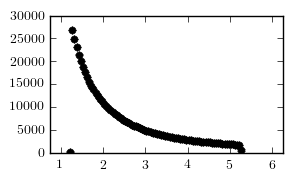

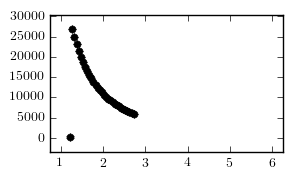

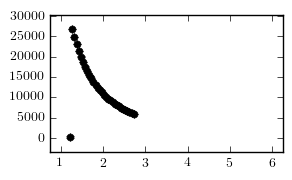

In [5]:
draw(asrootpy(h4tn_lt320.Projection(1)))
draw(asrootpy(h4tn_321.Projection(1)))
draw(asrootpy(h4tn_326.Projection(1)))
print('.')

In [5]:
def mdraw2d(hists, rows=2, cols=3, xlabel='', ylabel='',
            xlims=None, ylims=None, vmin=None, vmax=None,
            space=0, grid=False, figsize=None, **kwargs):
    nr, nc = rows, cols
    if figsize is None:
        figsize=goldenaspect(6.5,nr,nc)
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nr, nc, wspace=space, hspace=2*space, left=0.1, right=0.95, bottom=0.175)
    im = None
    vmax = 0.9*max([h.GetMaximum() for h in hists]) if vmax is None else vmax
    for irow in range(0,nr):
        for icol in range(0,nc):
            hnum = nc*irow+(icol+1)
            h = hists[hnum-1]
            ax = plt.subplot(gs[irow, icol])
            im = rplt.imshow(asrootpy(h), axes=ax, vmin=vmin, vmax=vmax, **kwargs)
#             rplt.hist2d(h, axes=ax, **kwargs) #, norm=LogNorm())
            if xlims is not None:
                plt.xlim(xlims)
            if ylims is not None:
                plt.ylim(ylims)
            if icol > 0:
                ax.set_yticklabels('')
            if irow+1 < nr:
                ax.set_xticklabels('')
            if grid is True:
                plt.grid()
    fig.add_axes([0.06, 0.105, 0.94, 0.895], frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
#     fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.975, 0.2, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    return fig

def get_acc2d(W, Q2, h4s, suf=''):
        if not isinstance(W, list):
            W = [W,W]
        if not isinstance(Q2, list):
            Q2 = [Q2,Q2]
        h4t = h4s[0][0]
        axW, axQ2 = h4t.GetAxis(0), h4t.GetAxis(1)
        Wbin0, Wbin1 = axW.FindBin(W[0]), axW.FindBin(W[1])
        Q2bin0, Q2bin1 = axQ2.FindBin(Q2[0]), axQ2.FindBin(Q2[1])
        if Wbin1 > Wbin0:
            Wbin1 = axW.FindBin(W[1]-0.0000001)
        if Q2bin1 > Q2bin0:
            Q2bin1 = axQ2.FindBin(Q2[1]-0.0000001)
        W[0], W[1] = axW.GetBinLowEdge(Wbin0), axW.GetBinUpEdge(Wbin1)
        Q2[0], Q2[1] = axQ2.GetBinLowEdge(Q2bin0), axQ2.GetBinUpEdge(Q2bin1)
        print('W: %.3f-%.3f, %d-%d'%(W[0],W[1],Wbin0,Wbin1))
        print('Q2: %.3f-%.3f, %d-%d'%(Q2[0],Q2[1],Q2bin0,Q2bin1))
        Wmid = 1000*(sum(W)/2.0)+0.5
        Q2mid = 1000*(sum(Q2)/2.0)+0.5
        Wwidth = 1000*(W[1]-W[0])+0.5
        Q2width = 1000*(Q2[1]-Q2[0])+0.5
        
        h2tr = []
        for i,(h4t,h4r) in enumerate(h4s,1):
            h4t_axW, h4r_axW = h4t.GetAxis(0), h4r.GetAxis(0)
            h4t_axQ2, h4r_axQ2 = h4t.GetAxis(1), h4r.GetAxis(1)
            
            h4t_axW.SetRange(Wbin0, Wbin1)
            h4t_axQ2.SetRange(Q2bin0, Q2bin1)
            h4r_axW.SetRange(Wbin0, Wbin1)
            h4r_axQ2.SetRange(Q2bin0, Q2bin1)
            
            h2t = asrootpy(h4t.Projection(2,3))
            h2t.SetName('h2t%d_%dx%d_%dx%d_%s'%(i, Wmid, Wwidth, Q2mid, Q2width, suf))
            h2r = asrootpy(h4r.Projection(2,3))
            h2r.SetName('h2r%d_%dx%d_%dx%d_%s'%(i, Wmid, Wwidth, Q2mid, Q2width, suf))
            h2a = h2r.Clone('h2r%d_%dx%d_%dx%d_%s'%(i, Wmid, Wwidth, Q2mid, Q2width, suf))
            h2a.Divide(h2t)
            h2tr.append((h2t,h2r,h2t))
        h2t_all = asrootpy(h2tr[0][0].Clone('h2t_%dx%d_%dx%d_%s'%(Wmid, Wwidth, Q2mid, Q2width, suf)))
        h2t_all.Reset()
        h2r_all = asrootpy(h2tr[0][1].Clone('h2r_%dx%d_%dx%d_%s'%(Wmid, Wwidth, Q2mid, Q2width, suf)))
        h2r_all.Reset()
        nbinsX, nbinsY = h2t_all.GetXaxis().GetNbins(), h2t_all.GetYaxis().GetNbins()
        for iy in range(1,nbinsY+1):
            for ix in range(1,nbinsX+1):
                tvals, tw8s = [], []
                rvals, rw8s = [], []
                for (h2t, h2r, _) in h2tr:
                    for h2, (vals, w8s) in zip([h2t,h2r],[(tvals,tw8s),(rvals,rw8s)]):
                        v = h2.GetBinContent(ix,iy)
                        e = h2.GetBinError(ix,iy)
                        w8 = 1/(e*e) if e>0 else 0
                        vals.append(v)
                        w8s.append(w8)
#                         if (iy==3 and ix==1):
#                             print('%s:\t%.3f\t%.3f\t%.3f'%(h2.GetName(),v,e,w8))
                tw8ed_mean, tsum_of_w8s = np.ma.average(tvals, weights=tw8s, returned=True)
                rw8ed_mean, rsum_of_w8s = np.ma.average(rvals, weights=rw8s, returned=True)
                h2t_all.SetBinContent(ix,iy,tw8ed_mean)
                h2r_all.SetBinContent(ix,iy,rw8ed_mean)
                terr = 0 if tsum_of_w8s==0 else 1/math.sqrt(tsum_of_w8s)
                rerr = 0 if rsum_of_w8s==0 else 1/math.sqrt(rsum_of_w8s)
                h2t_all.SetBinError(ix,iy,terr)
                h2r_all.SetBinError(ix,iy,rerr)
#                 if (iy==3 and ix==1):
#                     print(tvals)
#                     print(tw8s)
#                     print(rvals)
#                     print(rw8s)
        h2a_all = asrootpy(h2r_all.Clone('h2a_%dx%d_%dx%d_%s'%(Wmid, Wwidth, Q2mid, Q2width, suf)))
        h2a_all.Divide(h2t_all)
        return [(h2t_all,h2r_all,h2a_all)]+h2tr

W: 1.980-2.000, 20-20
Q2: 1.750-2.000, 21-25
W: 1.980-2.000, 20-20
Q2: 1.750-2.000, 21-25
W: 1.980-2.000, 20-20
Q2: 1.750-2.000, 21-25
W: 1.980-2.000, 20-20
Q2: 1.750-2.000, 21-25
h2a_1990x20_1875x250_0


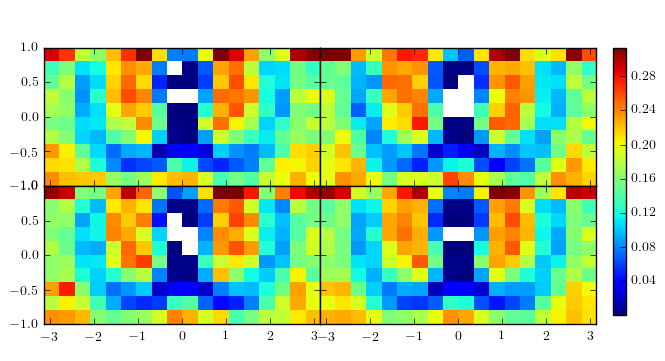

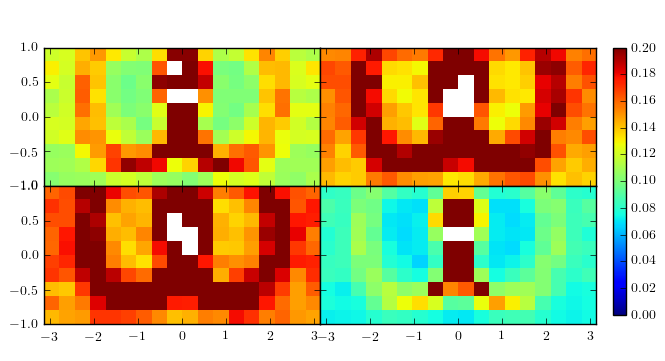

In [6]:
Q2 = [1.75,2]
W = 2
h2tra1 = get_acc2d(W, Q2, [(h4tn_lt320, h4rn_lt320)], '1')
h2tra2 = get_acc2d(W, Q2, [(h4tn_321, h4rn_321)], '2')
h2tra3 = get_acc2d(W, Q2, [(h4tn_326, h4rn_326)], '3')
h2tra0 = get_acc2d(W, Q2, [(h4tn_lt320, h4rn_lt320),(h4tn_321, h4rn_321),(h4tn_326, h4rn_326)], '0')

haccs = [h2tra[0][2] for h2tra in [h2tra1, h2tra2, h2tra3, h2tra0]]
def get_errs2d(h2):
    h2e = h2.Clone('%s_relerrs'%h2.GetName())
    h2e.Reset()
    nbinsX, nbinsY = h2e.GetXaxis().GetNbins(), h2e.GetYaxis().GetNbins()
    for iy in range(1,nbinsY+1):
        for ix in range(1,nbinsX+1):
            val = h2.GetBinContent(ix,iy)
            err = h2.GetBinError(ix,iy)
            rerr = 0 if val==0 else err/val
            h2e.SetBinContent(ix,iy,rerr)
    return h2e
herrs = [get_errs2d(hacc) for hacc in haccs]

# mdraw2d([h2tr0[0][0]], 1, 1)
# mdraw2d([h2tr0[0][1]], 1, 1)
# h2acc = asrootpy(h2tr0[0][1].Clone('h2acc_test'))
# h2acc.Divide(h2tr0[0][0])
# mdraw2d([h2acc], 1, 1)
mdraw2d(haccs,2,2)
mdraw2d(herrs,2,2, vmin=0, vmax=0.2)
print(h2tra0[0][2].GetName())

W: 1.720-1.740, 7-7
Q2: 4.500-5.000, 76-85
W: 1.820-1.840, 12-12
Q2: 4.500-5.000, 76-85
W: 1.920-1.940, 17-17
Q2: 4.500-5.000, 76-85
W: 2.020-2.040, 22-22
Q2: 4.500-5.000, 76-85
W: 2.120-2.140, 27-27
Q2: 4.500-5.000, 76-85
W: 2.220-2.240, 32-32
Q2: 4.500-5.000, 76-85
W: 2.320-2.340, 37-37
Q2: 4.500-5.000, 76-85
W: 2.420-2.440, 42-42
Q2: 4.500-5.000, 76-85
W: 2.520-2.540, 47-47
Q2: 4.500-5.000, 76-85
W: 2.620-2.640, 52-52
Q2: 4.500-5.000, 76-85
W: 2.720-2.740, 57-57
Q2: 4.500-5.000, 76-85
W: 2.820-2.840, 62-62
Q2: 4.500-5.000, 76-85
Q2=4.500	5.000


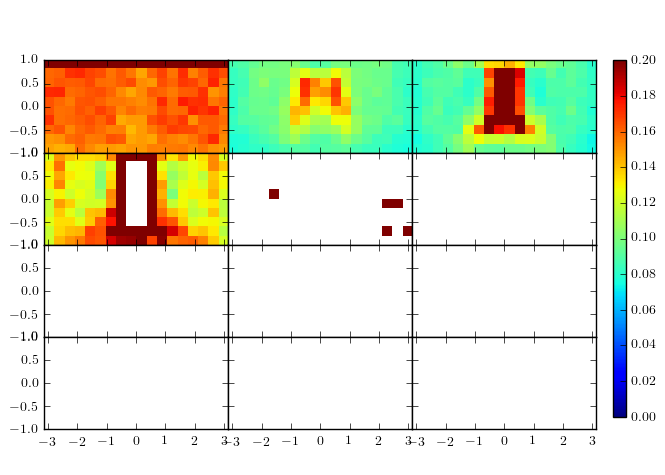

W: 1.720-1.740, 7-7
Q2: 4.000-4.500, 66-75
W: 1.820-1.840, 12-12
Q2: 4.000-4.500, 66-75
W: 1.920-1.940, 17-17
Q2: 4.000-4.500, 66-75
W: 2.020-2.040, 22-22
Q2: 4.000-4.500, 66-75
W: 2.120-2.140, 27-27
Q2: 4.000-4.500, 66-75
W: 2.220-2.240, 32-32
Q2: 4.000-4.500, 66-75
W: 2.320-2.340, 37-37
Q2: 4.000-4.500, 66-75
W: 2.420-2.440, 42-42
Q2: 4.000-4.500, 66-75
W: 2.520-2.540, 47-47
Q2: 4.000-4.500, 66-75
W: 2.620-2.640, 52-52
Q2: 4.000-4.500, 66-75
W: 2.720-2.740, 57-57
Q2: 4.000-4.500, 66-75
W: 2.820-2.840, 62-62
Q2: 4.000-4.500, 66-75
Q2=4.000	4.500


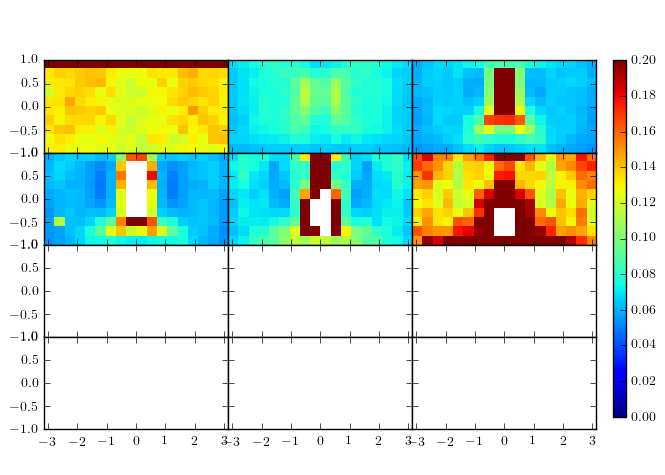

W: 1.720-1.740, 7-7
Q2: 3.500-4.000, 56-65
W: 1.820-1.840, 12-12
Q2: 3.500-4.000, 56-65
W: 1.920-1.940, 17-17
Q2: 3.500-4.000, 56-65
W: 2.020-2.040, 22-22
Q2: 3.500-4.000, 56-65
W: 2.120-2.140, 27-27
Q2: 3.500-4.000, 56-65
W: 2.220-2.240, 32-32
Q2: 3.500-4.000, 56-65
W: 2.320-2.340, 37-37
Q2: 3.500-4.000, 56-65
W: 2.420-2.440, 42-42
Q2: 3.500-4.000, 56-65
W: 2.520-2.540, 47-47
Q2: 3.500-4.000, 56-65
W: 2.620-2.640, 52-52
Q2: 3.500-4.000, 56-65
W: 2.720-2.740, 57-57
Q2: 3.500-4.000, 56-65
W: 2.820-2.840, 62-62
Q2: 3.500-4.000, 56-65
Q2=3.500	4.000


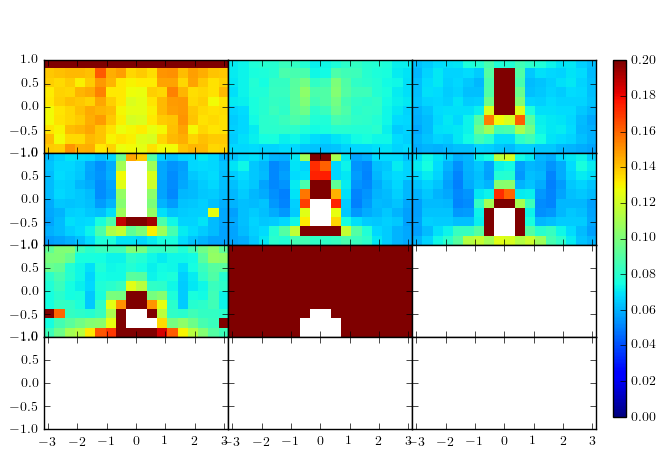

W: 1.720-1.740, 7-7
Q2: 3.000-3.500, 46-55
W: 1.820-1.840, 12-12
Q2: 3.000-3.500, 46-55
W: 1.920-1.940, 17-17
Q2: 3.000-3.500, 46-55
W: 2.020-2.040, 22-22
Q2: 3.000-3.500, 46-55
W: 2.120-2.140, 27-27
Q2: 3.000-3.500, 46-55
W: 2.220-2.240, 32-32
Q2: 3.000-3.500, 46-55
W: 2.320-2.340, 37-37
Q2: 3.000-3.500, 46-55
W: 2.420-2.440, 42-42
Q2: 3.000-3.500, 46-55
W: 2.520-2.540, 47-47
Q2: 3.000-3.500, 46-55
W: 2.620-2.640, 52-52
Q2: 3.000-3.500, 46-55
W: 2.720-2.740, 57-57
Q2: 3.000-3.500, 46-55
W: 2.820-2.840, 62-62
Q2: 3.000-3.500, 46-55
Q2=3.000	3.500


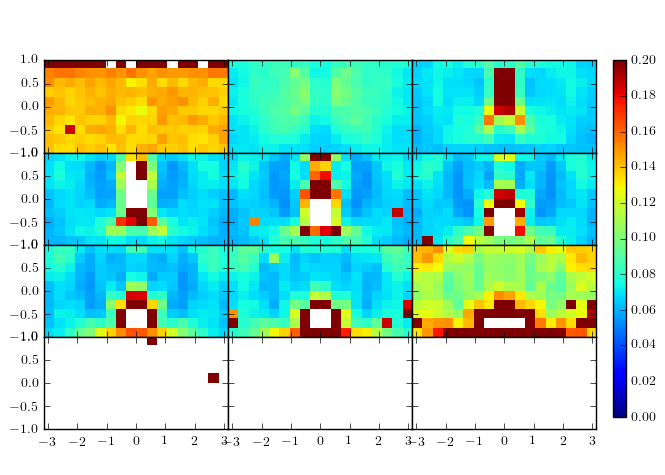

W: 1.720-1.740, 7-7
Q2: 2.500-3.000, 36-45
W: 1.820-1.840, 12-12
Q2: 2.500-3.000, 36-45
W: 1.920-1.940, 17-17
Q2: 2.500-3.000, 36-45
W: 2.020-2.040, 22-22
Q2: 2.500-3.000, 36-45
W: 2.120-2.140, 27-27
Q2: 2.500-3.000, 36-45
W: 2.220-2.240, 32-32
Q2: 2.500-3.000, 36-45
W: 2.320-2.340, 37-37
Q2: 2.500-3.000, 36-45
W: 2.420-2.440, 42-42
Q2: 2.500-3.000, 36-45
W: 2.520-2.540, 47-47
Q2: 2.500-3.000, 36-45
W: 2.620-2.640, 52-52
Q2: 2.500-3.000, 36-45
W: 2.720-2.740, 57-57
Q2: 2.500-3.000, 36-45
W: 2.820-2.840, 62-62
Q2: 2.500-3.000, 36-45
Q2=2.500	3.000


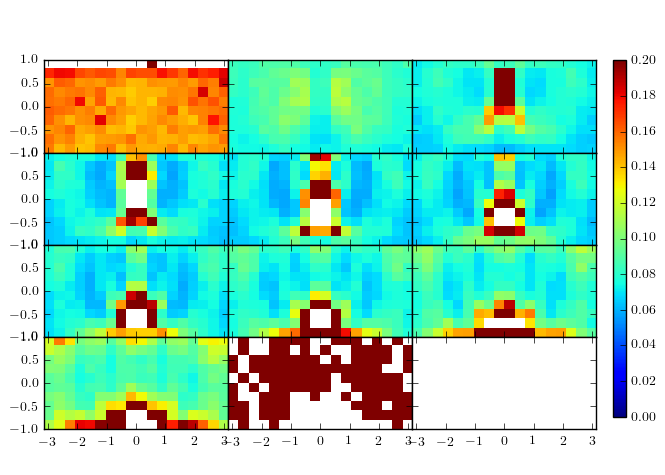

W: 1.720-1.740, 7-7
Q2: 2.000-2.500, 26-35
W: 1.820-1.840, 12-12
Q2: 2.000-2.500, 26-35
W: 1.920-1.940, 17-17
Q2: 2.000-2.500, 26-35
W: 2.020-2.040, 22-22
Q2: 2.000-2.500, 26-35
W: 2.120-2.140, 27-27
Q2: 2.000-2.500, 26-35
W: 2.220-2.240, 32-32
Q2: 2.000-2.500, 26-35
W: 2.320-2.340, 37-37
Q2: 2.000-2.500, 26-35
W: 2.420-2.440, 42-42
Q2: 2.000-2.500, 26-35
W: 2.520-2.540, 47-47
Q2: 2.000-2.500, 26-35
W: 2.620-2.640, 52-52
Q2: 2.000-2.500, 26-35
W: 2.720-2.740, 57-57
Q2: 2.000-2.500, 26-35
W: 2.820-2.840, 62-62
Q2: 2.000-2.500, 26-35
Q2=2.000	2.500


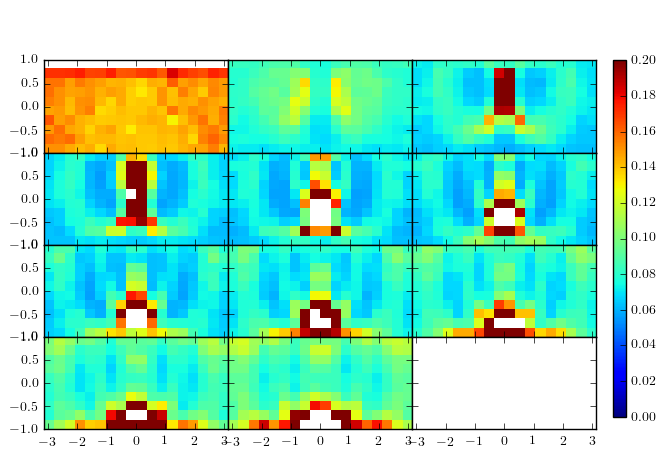

W: 1.720-1.740, 7-7
Q2: 1.500-2.000, 16-25
W: 1.820-1.840, 12-12
Q2: 1.500-2.000, 16-25
W: 1.920-1.940, 17-17
Q2: 1.500-2.000, 16-25
W: 2.020-2.040, 22-22
Q2: 1.500-2.000, 16-25
W: 2.120-2.140, 27-27
Q2: 1.500-2.000, 16-25
W: 2.220-2.240, 32-32
Q2: 1.500-2.000, 16-25
W: 2.320-2.340, 37-37
Q2: 1.500-2.000, 16-25
W: 2.420-2.440, 42-42
Q2: 1.500-2.000, 16-25
W: 2.520-2.540, 47-47
Q2: 1.500-2.000, 16-25
W: 2.620-2.640, 52-52
Q2: 1.500-2.000, 16-25
W: 2.720-2.740, 57-57
Q2: 1.500-2.000, 16-25
W: 2.820-2.840, 62-62
Q2: 1.500-2.000, 16-25
Q2=1.500	2.000


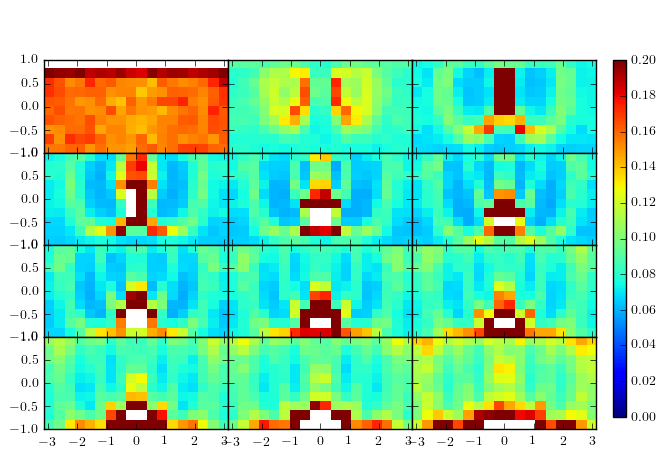

In [7]:
def get_errs2d(h2):
    h2e = h2.Clone('%s_relerrs'%h2.GetName())
    h2e.Reset()
    nbinsX, nbinsY = h2e.GetXaxis().GetNbins(), h2e.GetYaxis().GetNbins()
    for iy in range(1,nbinsY+1):
        for ix in range(1,nbinsX+1):
            val = h2.GetBinContent(ix,iy)
            err = h2.GetBinError(ix,iy)
            rerr = 0 if val==0 else err/val
            h2e.SetBinContent(ix,iy,rerr)
    return h2e

Q2s = list(reversed([[1.5,2], [2,2.5], [2.5,3], [3,3.5], [3.5,4], [4,4.5], [4.5,5]]))
Ws = [1.73+0.1*i for i in range(0,12)]
avg_accs = []

for Q2 in Q2s:
    haccs = [get_acc2d(W, Q2, [(h4tn_lt320, h4rn_lt320),(h4tn_321, h4rn_321),(h4tn_326, h4rn_326)])[0][2] for W in Ws]
    avg_accs.extend([((Q2,W),hacc.Integral()/(hacc.GetNbinsX()*hacc.GetNbinsY())) for (hacc,W) in zip(haccs,Ws)])
    herrs = [get_errs2d(hacc) for hacc in haccs]
    # mdraw2d([h2tr0[0][0]], 1, 1)
    # mdraw2d([h2tr0[0][1]], 1, 1)
    # h2acc = asrootpy(h2tr0[0][1].Clone('h2acc_test'))
    # h2acc.Divide(h2tr0[0][0])
    # mdraw2d([h2acc], 1, 1)
#     mdraw2d(haccs,4,3, vmax=0.5)
    mdraw2d(herrs,4,3, vmin=0, vmax=0.2)
    print('Q2=%.3f\t%.3f'%(Q2[0],Q2[1]))
    plt.show()

nan


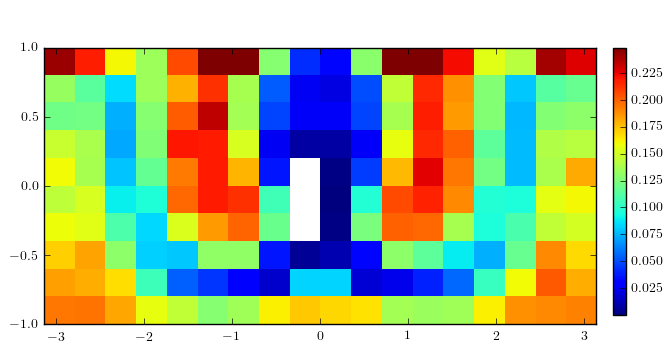

In [8]:
# [avg_acc for avg_acc in avg_accs if round(avg_acc[0][1],3)==2.03]
# avg_accs
mdraw2d([haccs[3]],1,1)
print(haccs[3].Integral())

In [9]:
haccs, herrs = [], []
for i,h4 in enumerate([h4an_lt320, h4an_321, h4an_326], 1):
    hacc = rpy.plotting.Hist(1000,0,1,title='acc %d'%i)
    herr = rpy.plotting.Hist(1000,0,1,title='err %d'%i)
    for ibin in range(0,h4.GetNbins()):
        bincoord = array('i', [0,0,0,0])
        val = h4.GetBinContent(ibin, bincoord)
        err = 0 if val==0 else h4.GetBinError(ibin)/val
        Q2 = h4.GetAxis(1).GetBinLowEdge(bincoord[1])
        if Q2<2.5:
            hacc.Fill(val)
            herr.Fill(err)
    haccs.append(hacc)
    herrs.append(herr)

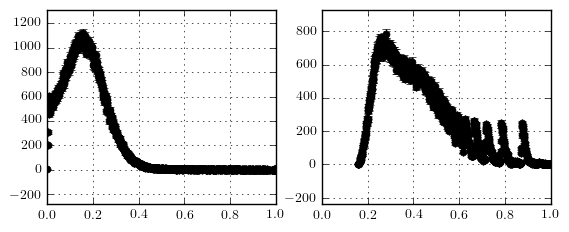

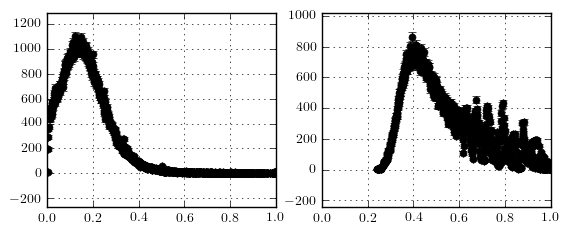

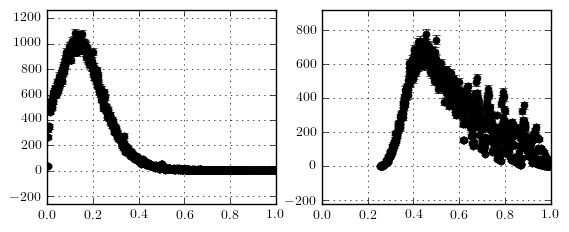

In [10]:
for hacc,herr in zip(haccs,herrs):
    hacc.SetBinContent(1,0)
    herr.SetBinContent(1,0)
    fig = draw(hacc, 2, 1, 1, figsize=(6.5,2.5))
    fig = draw(herr, 2, 1, 2, fig)
    for ax in fig.axes:
        ax.grid()

# Scratch

## Q2 Yield, E1F

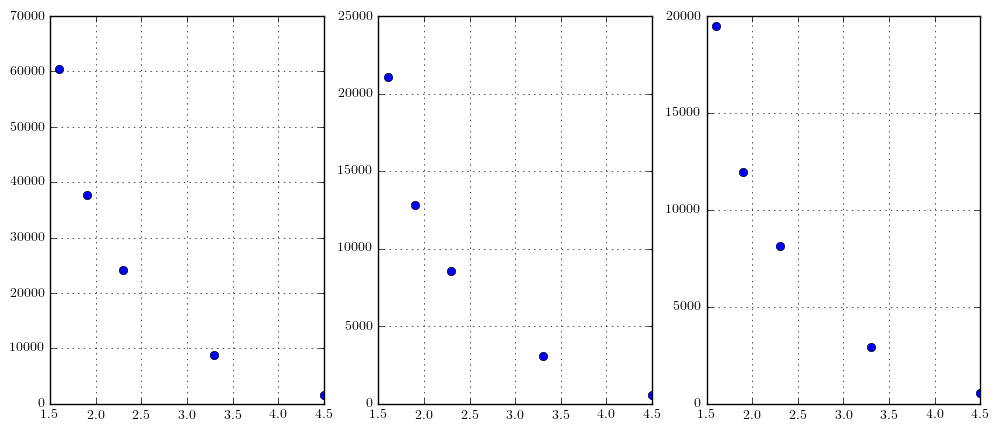

In [2]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,5))
hq2_1 = draw_q2('../e1f6/test/e1f_exp_top1_badsc_pcor.root',
                'h6_mmp_top1_badsc_pcor/hbd_yield', ax1)
hq2_2 = draw_q2('../e1f6/test/e1f_exp_top1_badsc_pcor.root',
                'h6_mmp_top1_badsc_pcor/hbd_yield', ax2, True)
hq2_3 = draw_q2('../e1f6/test/e1f_exp_top1_badsc_pcor.root',
                'h6_mmp_top1_badsc_pcor/hbd_yield', ax3, True, 0.7, 0.85)
plt.show()

In [12]:
with root_open('../e1f6/test/e1f_exp_top1_badsc_pcor.root') as fin:
    hbd = fin['h6_mmp_top1_badsc_pcor/hbd_yield']
    

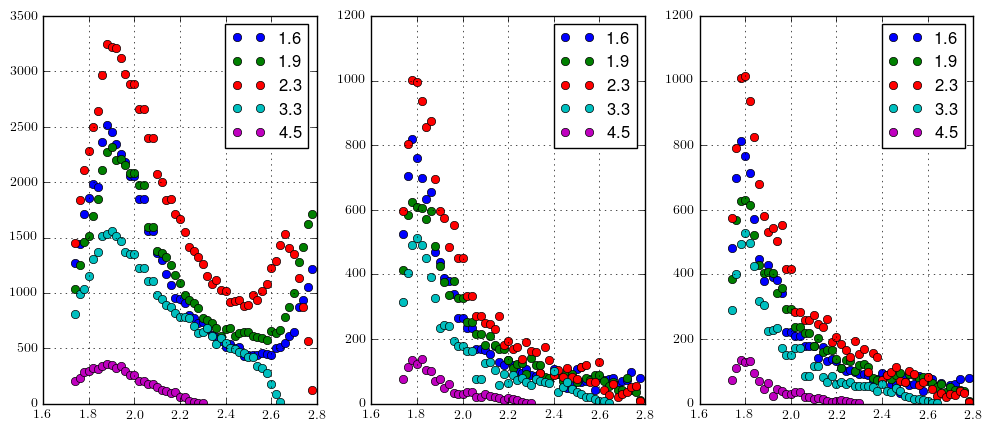

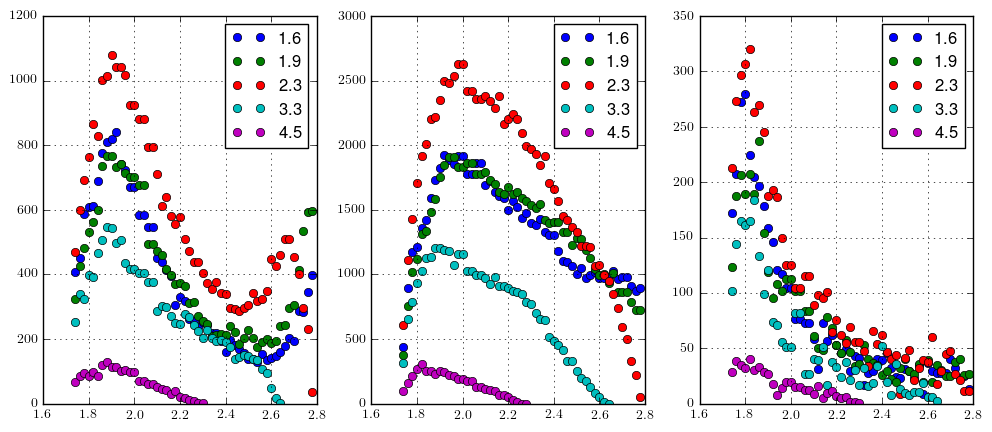

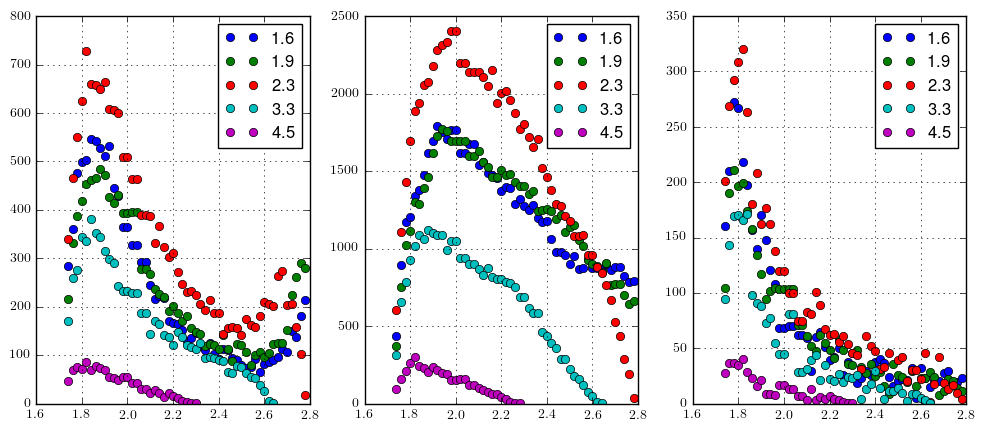

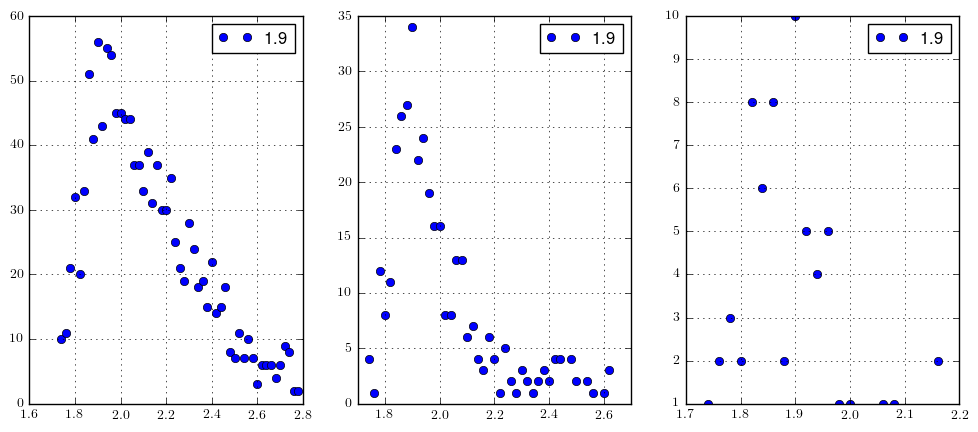

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,5))
draw_w('../e1f6/test/e1f_exp_top1_badsc_pcor.root',
       'h6_mmp_top1_badsc_pcor/hbd_yield', ax1)
draw_w('../e1f6/test/e1f_exp_top1_badsc_pcor.root',
       'h6_mmp_top1_badsc_pcor/hbd_yield', ax2, True)
draw_w('../e1f6/test/e1f_exp_top1_badsc_pcor.root',
       'h6_mmp_top1_badsc_pcor/hbd_yield', ax3, True, 0.7, 0.85)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,5))
draw_w('../e1f6/test/e1f_exp_h6_top1_badscremoved_ho.root',
       'h6_mmp_top1_badsc/hbd_yield', ax1)
draw_w('../e1f6/test/e1f_sim_h6_top1_badscremoved_ho.root',
       'h6_mmp_top1_badsc/hbd_yield', ax2)
draw_w('../e1f6/test/e1f_exp_h6_top1_badscremoved_ho.root',
       'h6_mmp_top1_badsc/hbd_yield', ax3, True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,5))
draw_w('../e1f6/test/e1f_exp_h6_top1_badscremoved_ho.root',
       'h6_mmp_top1_badsc/hbd_yield', ax1, False, 0.7, 0.85)
draw_w('../e1f6/test/e1f_sim_h6_top1_badscremoved_ho.root',
       'h6_mmp_top1_badsc/hbd_yield', ax2, False, 0.7, 0.85)
draw_w('../e1f6/test/e1f_exp_h6_top1_badscremoved_ho.root',
       'h6_mmp_top1_badsc/hbd_yield', ax3, True, 0.7, 0.85)

W = np.arange(1.74, 2.8, 0.02)
fig, axes = plt.subplots(1,3, figsize=(12,5))
for tpath, ax in zip(['h6_3pi/hbd_yield', 'h6_4pi/hbd_yield', 'h6_5pi/hbd_yield'], axes):
    for q2 in [1.6, 1.9, 2.3, 3.3, 4.5]:
        Y = []
        X = []
        for w in W:
            hmmp = get_hmmp(w,q2, '../e1f6/test/ps.root', tpath)
            wbin0 = hmmp.FindBin(0.7)
            wbin1 = hmmp.FindBin(0.9)
            y = hmmp.integral(wbin0, wbin1)
            if y > 0:
                Y.append(y)
                X.append(w)
        if len(Y) > 0:
            ax.plot(X, Y, 'o', label='%.1f'%q2)
    ax.legend()
    ax.grid()

/home/ephelps/projects/anaconda2/envs/root6_py3/lib/python3.4/site-packages/matplotlib/artist.py:210: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


hmmp_1990_1625 3072.880979938274
hmmp_1990_1625 96804.0
hmmp_1990_1925 3582.52366255144
hmmp_1990_1925 103894.0
hmmp_1990_2495 4453.427854938273
hmmp_1990_2495 118569.0
hmmp_1990_3445 1597.609696502058
hmmp_1990_3445 46961.0
hmmp_1990_4750 321.0362654320985
hmmp_1990_4750 9055.0


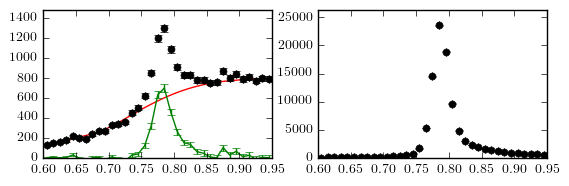

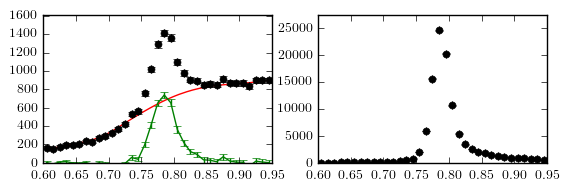

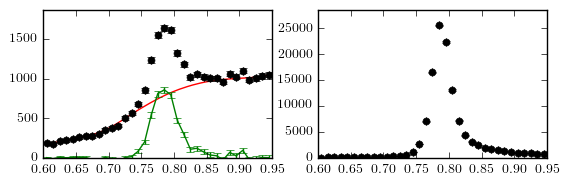

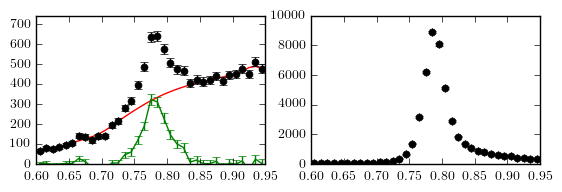

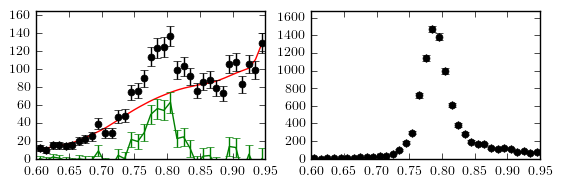

In [3]:
for q2 in [1.6, 1.9, 2.3, 3.3, 4.5]:
    hmmp = get_hmmp(2,q2)
    hmmp2 = get_hmmp(2,q2, '../e1f6/test/e1f_sim_skim_small_top123_top1_hists_only.root', 'h6recon_top123_top1/hbd_yield')
    fig = mdraw([hmmp, hmmp2], 2)
    for iax, h in enumerate([hmmp, hmmp2]):
        hbgsubd = h
        if iax==0:
            (hbgsubd, hbg, hsig) = get_hsubd(h)
            ax = fig.axes[iax]
#             ax.plot(list(hsig.x()), list(hsig.y()))
            ax.plot(*interp_h1(hbg), color='r', axes=ax)
            Yerr = list([y[0] for y in hbgsubd.yerr()])
            ax.errorbar(list(hbgsubd.x()), list(hbgsubd.y()), Yerr)
        print(h.get_name(), hbgsubd.integral(1, hbgsubd.get_nbins_x()))
        
#     (hbgsubd, hbg, h) = get_hsubd(hmmp)
#     fig = draw(h, ecolor='k', marker='')
#     plt.plot(*interp_h1(hbg), color='r')
#     # draw(hbg, fig=fig)
#     # draw(hbgsubd, fig=fig, ecolor='g', marker='')
#     rplt.errorbar(hbgsubd, ecolor='g', marker='', xerr=False)
#     print(hmmp.get_name(), hbgsubd.integral(1, hbgsubd.get_nbins_x()))

In [55]:
q2 = 2
W = np.arange(1.8, 2.8, 0.02)
Y = [get_hsubd(get_hmmp(w,q2))[0].integral() for w in W]

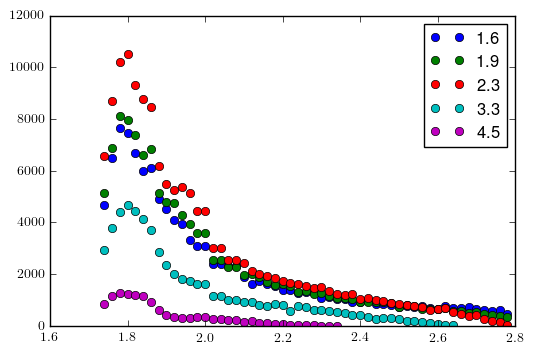

KeyboardInterrupt: 

In [4]:

W = np.arange(1.74, 2.8, 0.02)
for q2 in [1.6, 1.9, 2.3, 3.3, 4.5]:
    Y = []
    X = []
    for w in W:
        y = get_hsubd(get_hmmp(w,q2))[0].integral()
        if y > 0:
            Y.append(y)
            X.append(w)
    plt.plot(X, Y, 'o', label='%.1f'%q2)
plt.legend()
plt.show()

W = np.arange(1.8, 2.8, 0.02)
for q2 in [1.6, 1.9, 2.3, 3.3, 4.5]:
    Y = []
    X = []
    for w in W:
        y = get_hmmp(w,q2, '../e1f6/test/e1f_sim_skim_small_top123_top1_hists_only.root', 'h6recon_top123_top1/hbd_yield').integral()
        if y > 0:
            Y.append(y)
            X.append(w)
    plt.plot(X, Y, 'o', label='%.1f'%q2)
plt.legend()
plt.show()

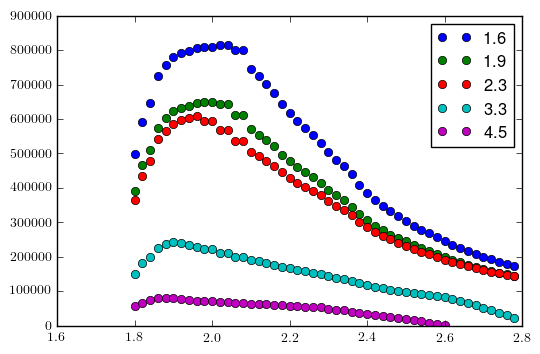

In [7]:
W = np.arange(1.8, 2.8, 0.02)
for q2 in [1.6, 1.9, 2.3, 3.3, 4.5]:
    Y = []
    X = []
    for w in W:
        y = get_hmmp(w,q2, '../e1f6/test/e1f_sim_hists_only.root', 'h6thrown/hbd_yield').integral()
        if y > 0:
            Y.append(y)
            X.append(w)
    plt.plot(X, Y, 'o', label='%.1f'%q2)
plt.legend()

In [9]:
W

array([ 1.8 ,  1.82,  1.84,  1.86,  1.88,  1.9 ,  1.92,  1.94,  1.96,
        1.98,  2.  ,  2.02,  2.04,  2.06,  2.08,  2.1 ,  2.12,  2.14,
        2.16,  2.18,  2.2 ,  2.22,  2.24,  2.26,  2.28,  2.3 ,  2.32,
        2.34,  2.36,  2.38,  2.4 ,  2.42,  2.44,  2.46,  2.48,  2.5 ,
        2.52,  2.54,  2.56,  2.58,  2.6 ,  2.62,  2.64,  2.66,  2.68,
        2.7 ,  2.72,  2.74,  2.76,  2.78])

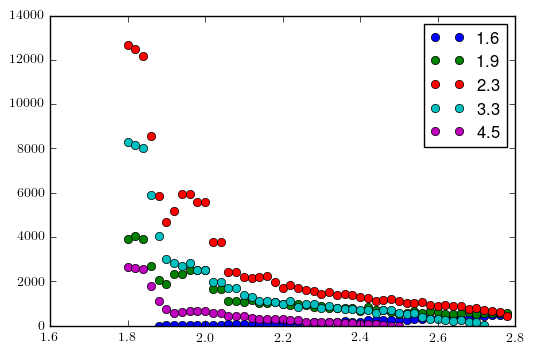

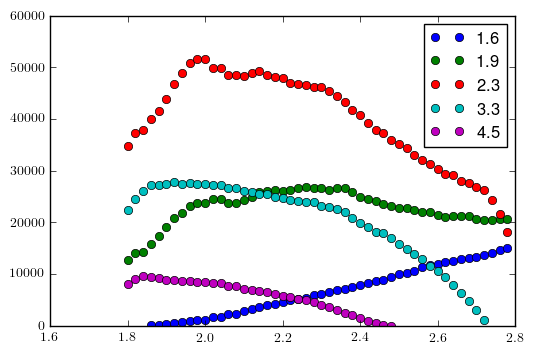

In [3]:
W = np.arange(1.8, 2.8, 0.02)
for q2 in [1.6, 1.9, 2.3, 3.3, 4.5]:
    Y = []
    X = []
    for w in W:
        y = get_hsubd(get_hmmp(w,q2, '../e1f6/test/h6_top1_e16_exp.root'))[0].integral()
        if y > 0:
            Y.append(y)
            X.append(w)
    plt.plot(X, Y, 'o', label='%.1f'%q2)
plt.legend()
plt.show()

W = np.arange(1.8, 2.8, 0.02)
for q2 in [1.6, 1.9, 2.3, 3.3, 4.5]:
    Y = []
    X = []
    for w in W:
        y = get_hmmp(w,q2, '../e1f6/test/e16_sim_skim_small_top123_top1_hists_only.root', 'h6recon_top123_top1/hbd_yield').integral()
        if y > 0:
            Y.append(y)
            X.append(w)
    plt.plot(X, Y, 'o', label='%.1f'%q2)
plt.legend()

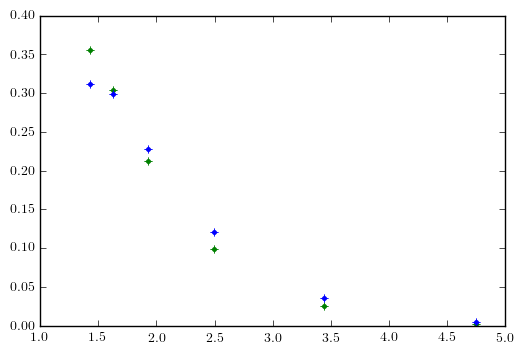

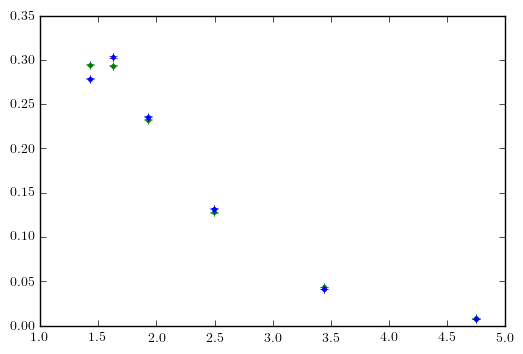

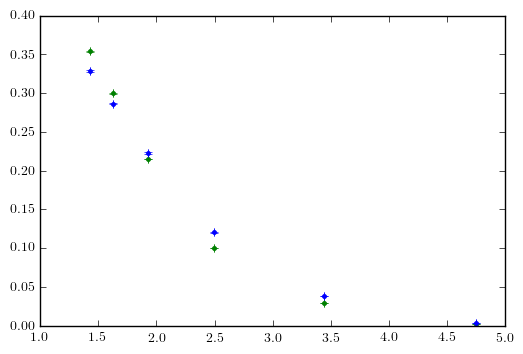

In [24]:
with root_open('../e1f6/test/e1f_sim_skim_small_top123_top1_hists_only.root') as fin:
    tpath = 'h6recon_top123_top1/hbd_yield'
    h6 = fin[tpath]
    for iax in range(0, 6):
        ax = h6.GetAxis(iax)
        ax.SetRange(1, ax.GetNbins())
    hQ2 = h6.Projection(1)
    hQ2.Scale(1, 'width')
    hQ2.Scale(1/hQ2.Integral())
    hQ2 = asrootpy(hQ2)
    plt.errorbar(list(hQ2.x()), list(hQ2.y()), list([y[0] for y in hQ2.yerr()]),
                 False, 'g.')

with root_open('../e1f6/test/h6_top1_e1f_exp.root') as fin:
    tpath = 'h6_mmp_top1/hbd_yield'
    h6 = fin[tpath]
    for iax in range(0, 6):
        ax = h6.GetAxis(iax)
        ax.SetRange(1, ax.GetNbins())
    hQ2 = h6.Projection(1)
    hQ2.Scale(1, 'width')
    hQ2.Scale(1/hQ2.Integral())
    hQ2 = asrootpy(hQ2)
    plt.errorbar(list(hQ2.x()), list(hQ2.y()), list([y[0] for y in hQ2.yerr()]),
                 False, 'b.')

plt.show()

with root_open('../e1f6/test/e1f_sim_skim_small_top123_top1_hists_only.root') as fin:
    tpath = 'h6recon_top123_top1/hbd_yield'
    h6 = fin[tpath]
    for iax in range(0, 6):
        ax = h6.GetAxis(iax)
        ax.SetRange(1, ax.GetNbins())
    iwlo = h6.GetAxis(0).FindBin(1.8)
    iwhi = h6.GetAxis(0).FindBin(1.9)
    h6.GetAxis(0).SetRange(iwlo, iwhi)
    hQ2 = h6.Projection(1)
    hQ2.Scale(1, 'width')
    hQ2.Scale(1/hQ2.Integral())
    hQ2 = asrootpy(hQ2)
    plt.errorbar(list(hQ2.x()), list(hQ2.y()), list([y[0] for y in hQ2.yerr()]),
                 False, 'g.')

with root_open('../e1f6/test/h6_top1_e1f_exp.root') as fin:
    tpath = 'h6_mmp_top1/hbd_yield'
    h6 = fin[tpath]
    for iax in range(0, 6):
        ax = h6.GetAxis(iax)
        ax.SetRange(1, ax.GetNbins())
    iwlo = h6.GetAxis(0).FindBin(1.8)
    iwhi = h6.GetAxis(0).FindBin(1.9)
    h6.GetAxis(0).SetRange(iwlo, iwhi)
    hQ2 = h6.Projection(1)
    hQ2.Scale(1, 'width')
    hQ2.Scale(1/hQ2.Integral())
    hQ2 = asrootpy(hQ2)
    plt.errorbar(list(hQ2.x()), list(hQ2.y()), list([y[0] for y in hQ2.yerr()]),
                 False, 'b.')

plt.show()

with root_open('../e1f6/test/e1f_sim_skim_small_top123_top1_hists_only.root') as fin:
    tpath = 'h6recon_top123_top1/hbd_yield'
    h6 = fin[tpath]
    for iax in range(0, 6):
        ax = h6.GetAxis(iax)
        ax.SetRange(1, ax.GetNbins())
    iwlo = h6.GetAxis(0).FindBin(2.1)
    iwhi = h6.GetAxis(0).FindBin(2.2)
    h6.GetAxis(0).SetRange(iwlo, iwhi)
    hQ2 = h6.Projection(1)
    hQ2.Scale(1, 'width')
    hQ2.Scale(1/hQ2.Integral())
    hQ2 = asrootpy(hQ2)
    plt.errorbar(list(hQ2.x()), list(hQ2.y()), list([y[0] for y in hQ2.yerr()]),
                 False, 'g.')

with root_open('../e1f6/test/h6_top1_e1f_exp.root') as fin:
    tpath = 'h6_mmp_top1/hbd_yield'
    h6 = fin[tpath]
    for iax in range(0, 6):
        ax = h6.GetAxis(iax)
        ax.SetRange(1, ax.GetNbins())
    iwlo = h6.GetAxis(0).FindBin(2.1)
    iwhi = h6.GetAxis(0).FindBin(2.2)
    h6.GetAxis(0).SetRange(iwlo, iwhi)
    hQ2 = h6.Projection(1)
    hQ2.Scale(1, 'width')
    hQ2.Scale(1/hQ2.Integral())
    hQ2 = asrootpy(hQ2)
    plt.errorbar(list(hQ2.x()), list(hQ2.y()), list([y[0] for y in hQ2.yerr()]),
                 False, 'b.')

plt.show()

In [17]:
def bgfun(x, p):
    pol2 = p[0]+p[1]*x[0]+p[2]*x[0]*x[0]
    #print(p[3], x[0], p[4])
    drop = 1 - math.erf((x[0]-p[3])/p[4])
#     if (x[0] > 0.5 and x[0] < 0.6) or (x[0] > 0.7 and x[0] < 0.92): r.TF1.RejectPoint()
    if x[0] > 0.7 and x[0] < 0.89: r.TF1.RejectPoint()
    return pol2*drop/2

def drop(x, p):
    return 1 - math.erf((x[0]-p[0])/p[1])

def gausdrop(x, p):
    gaus = p[0]*math.exp(-0.5*pow(((x[0]-p[1])/p[2]), 2))
    return gaus*drop(x, [p[3],p[4]])/2

def fitfun(x, p):
    pol2 = p[0]+p[1]*x[0]+p[2]*x[0]*x[0]
    gaus = p[5]*math.exp(-0.5*pow(((x[0]-p[6])/p[7]), 2))
    return (gaus+pol2)*drop(x, [p[3],p[4]])/2

def fit_mmp(h, fout=None):
    '''
    Fit histogram with (gauss+pol2)*(erf cutoff).
    Return tuple of W, Q2, histogram, function, fit parameters, chi2, FCstatu.
    + Cutoff parameters estimated from phase space edge from W.
    + Background parameters estimated by fitting with signal, skipping signal region.
    + Signal parameters estimated by subtracting initial background and fitting in
      vicinity of the omega mass mean.
    + Full histogram fitted with combined function.
    TODO:  add option to provide initial parameter estimates.
    '''
    result = []
    # ######### get W,Q2 bin information
    W, Q2 = h.GetName().split('_')[1:]
    W = float(W)/1000.0
    Q2 = float(Q2)/1000.0
    wlow, whigh = W-0.010, W+0.010  # W bins are 20 MeV
    # ######### calculate MMp phase space edge range
    mmpax = h.GetXaxis()
    x0 = math.sqrt(wlow**2+MASS_P**2-2*wlow*MASS_P)
    x1 = math.sqrt(whigh**2+MASS_P**2-2*whigh*MASS_P)
    # ######### setup fit functions
    fgaus = r.TF1('fgaus', gausdrop, 0.6, 0.95, 5) #0.4, 1.2, 5)
    fgaus.SetParameters(r.Double(20), r.Double(0.783), r.Double(0.20), r.Double((x1+x0)*0.5), r.Double(x1-x0))
    fgaus.SetParLimits(0, 0.01, 1e4)
    fgaus.SetParLimits(1, 0.773, 0.793)
    fgaus.SetParLimits(2, 0.011, 0.035)
    fgaus.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
    fgaus.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
    fbg = r.TF1('fbg', bgfun, 0.4, 1.2, 5)
    fbg.SetParameters(r.Double(0), r.Double(0), r.Double(0), r.Double((x1+x0)*0.5), r.Double(x1-x0))
    if x0 > 0.95:
        fbg.FixParameter(3, x1)
        fbg.FixParameter(4, x1-x0)
    else:
        fbg.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
        fbg.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
#     fbg.SetParLimits(2, 0.01, 1e9)
    # ######### fit background for parameter estimates
    h.Fit(fbg, '', 'goff', 0.6, 0.95) #0.4, 1.2)
    if True:  #r.gMinuit.fCstatu.startswith('CONV'):
        # ######### fit signal for parameter estimates
        wsig = h.Clone()
        wsig.Add(fbg, -1)
        sigint = wsig.Integral(mmpax.FindBin(0.76), mmpax.FindBin(0.80))
        sigint = sigint if sigint > 0 else h.Integral(mmpax.FindBin(0.76), mmpax.FindBin(0.80))
        fgaus.SetParLimits(0, 0.1*sigint, 2*sigint)
        wsig.Fit(fgaus, '', '', 0.76, 0.80)
        if True:  #r.gMinuit.fCstatu.startswith('CONV'):
            # ######### create combined signal-background function and set parameters
            fsigbg = r.TF1('fsigbg', fitfun, 0.4, 1.2, 8)
#             fsigbg.SetParameters(r.Double(0), r.Double(0), r.Double(0.02), r.Double((x1+x0)*0.5), r.Double(x1-x0), r.Double(20), r.Double(0.783), r.Double(0.022))
            p0, p1, p2 = fbg.GetParameter(0), fbg.GetParameter(1), fbg.GetParameter(2)
            fsigbg.SetParameters(fbg.GetParameter(0), fbg.GetParameter(1), fbg.GetParameter(2),
                                 fbg.GetParameter(3), fbg.GetParameter(4),
                                 fgaus.GetParameter(0), fgaus.GetParameter(1), fgaus.GetParameter(2))
            fsigbg.SetParLimits(0, 0.85*p0, 1.15*p0)
            fsigbg.SetParLimits(1, 0.85*p1, 1.15*p1)
            fsigbg.SetParLimits(2, 0.85*p2, 1.15*p2)
#             fsigbg.SetParLimits(2, 0.0001, 1e9)
            fsigbg.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
            fsigbg.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
            #fsigbg.SetParLimits(3,0.65,2)
            #fsigbg.SetParLimits(4,0.03, 0.2)
            fsigbg.SetParLimits(5, 0.1*sigint, 2*sigint)
            fsigbg.SetParLimits(6, 0.773, 0.793)
            fsigbg.SetParLimits(7, 0.011, 0.035)
            # ######### fit signal and background
            h.Fit(fsigbg, '', 'goff', 0.6, 0.95) #0.4, 1.2)
            if True:  #r.gMinuit.fCstatu.startswith('CONV'):
                q = fsigbg.GetChisquare()/fsigbg.GetNDF() if fsigbg.GetNDF() > 0 else -1
                result += [W,Q2]
                result.append(h),
                result.append(tuple([fbg.GetParameter(ipar) for ipar in range(0,5)]))
                result.append(h.GetListOfFunctions()[0])
                result.append(tuple([fsigbg.GetParameter(ipar) for ipar in range(0,8)]))
                result.append(q)
                result.append(r.gMinuit.fCstatu)
                if fout is not None: fout.WriteObject(h, h.GetName())
    return tuple(result) if result is not None else None

.
.


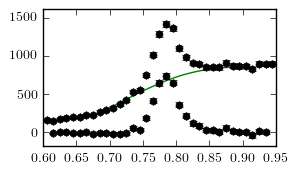

In [148]:
fig = draw(hmmp)
print('.')
s = r.TSpectrum()
h = asrootpy(s.Background(hmmp, 5))
xlin = np.linspace(0.7, 0.9)
ybg = [get_interpf(h)(x) for x in xlin]
plt.plot(xlin, ybg)
hmmp_bgsubd = hmmp.clone('%s_bgsubd'%hmmp.get_name())

hmmp_bgsubd.add(h, -1)
draw(hmmp_bgsubd, fig=fig)
print('.')

In [111]:
W, Q2, hmmp, bgparms, f, parms, q, stat = fit_mmp(hmmp)

INFO:ROOT.TCanvas.Print] png file /tmp/tmprjub4fea.png has been created


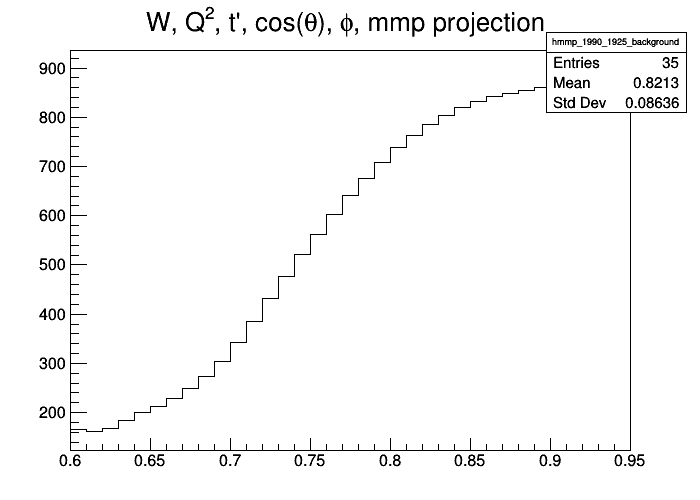

In [117]:
asrootpy(o)

5.952412836947625 CONVERGED 


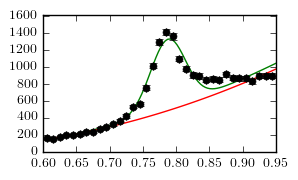

In [112]:
draw(hmmp)
fitted_points = get_points_from_TF1(f, 0.6, 0.95)
X, Y = zip(*fitted_points)
plt.plot(X, Y)
# parms_bg = [f.GetParameter(i) for i in range(0,5)]
# Y_bg = [bgfun([x], parms_bg) for x in X]
Y_bg = [bgfun([x], bgparms) for x in X]
plt.plot(X, Y_bg)
print(q, stat)

In [72]:
parms

(-326.08138487454687,
 -433.03850030311463,
 1947.8219429845035,
 1.0467279736700723,
 0.03999998327467909,
 806.5400083935685,
 0.7874544211218794,
 0.024694965398577975)